# Load the data

In [15]:
import pandas as pd
import numpy as np
from pathlib import Path
data_dir = Path("data")

X_test = data_dir / "X_test.csv"
y_train = data_dir / "y_train.csv"
X_train = data_dir / "X_train.csv"

X_test = pd.read_csv(X_test, index_col="id")
X_test.index = X_test.index.astype(int)

y_train = pd.read_csv(y_train, index_col="id")
y_train.index = y_train.index.astype(int)

X_train = pd.read_csv(X_train, index_col="id")
X_train.index = X_train.index.astype(int)

print(f"X_train.shape {X_train.shape}, y_train.shape {y_train.shape}, X_test.shape {X_test.shape}")

print(X_train.head())

X_train.shape (1212, 832), y_train.shape (1212, 1), X_test.shape (776, 832)
              x0            x1           x2             x3          x4  \
id                                                                       
0   14168.823171  10514.380717  3316.149698   94230.695124  102.386606   
1   17757.037554           NaN  4101.016273   92959.527633         NaN   
2   14226.656663  11029.642499          NaN  124055.600561  100.542483   
3    8766.012436   7384.202998  2147.308418  100157.719990  104.855061   
4   13801.016418  13269.493652  3408.316953   92048.527786  103.759758   

            x5            x6            x7            x8         x9  ...  \
id                                                                   ...   
0    92.677127  11108.748199  10866.505510  10837.622093  10.227734  ...   
1    99.855168  10013.959449  10826.607494  10076.101597  11.436970  ...   
2    92.860892           NaN  10492.342868           NaN  10.810076  ...   
3   101.929026  10050.049

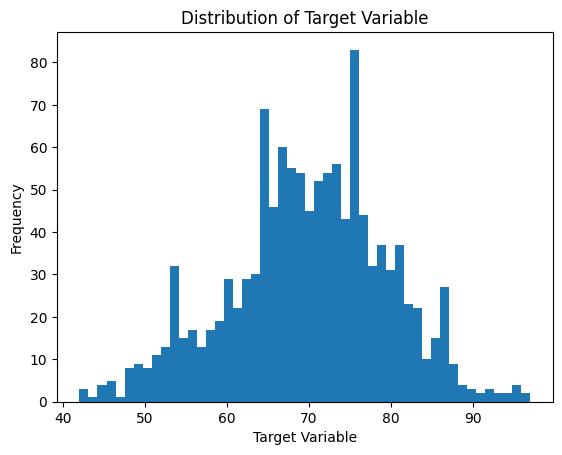

In [16]:
#have a look at the data
import matplotlib.pyplot as plt
plt.hist(y_train.values, bins=50)
plt.xlabel("Target Variable")
plt.ylabel("Frequency")
plt.title("Distribution of Target Variable")
plt.show()


# 1. imputing missing values

First we impute nan values with the mean for each feature

In [17]:
X_train.fillna(pd.Series(X_train.mean()), inplace=True)
print(f"Nan-values: {X_train.isna().sum().sum()}")
print(X_train.head())
X_test.fillna(pd.Series(X_test.mean()), inplace=True)
y_train.fillna(pd.Series(y_train.mean()), inplace=True)

Nan-values: 0
              x0            x1           x2             x3          x4  \
id                                                                       
0   14168.823171  10514.380717  3316.149698   94230.695124  102.386606   
1   17757.037554  10950.160761  4101.016273   92959.527633  105.070358   
2   14226.656663  11029.642499  3430.837498  124055.600561  100.542483   
3    8766.012436   7384.202998  2147.308418  100157.719990  104.855061   
4   13801.016418  13269.493652  3408.316953   92048.527786  103.759758   

            x5            x6            x7            x8         x9  ...  \
id                                                                   ...   
0    92.677127  11108.748199  10866.505510  10837.622093  10.227734  ...   
1    99.855168  10013.959449  10826.607494  10076.101597  11.436970  ...   
2    92.860892   9983.055476  10492.342868  10495.835570  10.810076  ...   
3   101.929026  10050.049932  10499.521099  10525.030989  10.092109  ...   
4    95.789

# 2. Outlier detection
Next we build an outlier detection model to classify samples as outliers and eventually remove them

In [18]:
#outlier detection using isolation forest and guessing the contamination to be 5%

from sklearn.ensemble import IsolationForest
outlier_model = IsolationForest(contamination=0.05, random_state=42)
outlier_model.fit(X_train)
outlier_preds = outlier_model.predict(X_train)
isoforest_outlier_indices = set(np.where(outlier_preds == -1)[0])

print("Outlier indices:", isoforest_outlier_indices)

print(f"Number of outliers detected: {len(isoforest_outlier_indices)}")

Outlier indices: {np.int64(3), np.int64(515), np.int64(645), np.int64(900), np.int64(1031), np.int64(648), np.int64(906), np.int64(397), np.int64(917), np.int64(278), np.int64(24), np.int64(1048), np.int64(30), np.int64(416), np.int64(1056), np.int64(1058), np.int64(805), np.int64(167), np.int64(297), np.int64(681), np.int64(428), np.int64(306), np.int64(821), np.int64(694), np.int64(697), np.int64(953), np.int64(573), np.int64(190), np.int64(575), np.int64(64), np.int64(321), np.int64(448), np.int64(837), np.int64(70), np.int64(583), np.int64(75), np.int64(460), np.int64(972), np.int64(1102), np.int64(335), np.int64(474), np.int64(91), np.int64(731), np.int64(860), np.int64(991), np.int64(480), np.int64(225), np.int64(1120), np.int64(100), np.int64(229), np.int64(740), np.int64(231), np.int64(234), np.int64(362), np.int64(1137), np.int64(114), np.int64(882), np.int64(502), np.int64(1144), np.int64(506), np.int64(1150)}
Number of outliers detected: 61


In [19]:
# outlier detection using OneClassSVM

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

svm_model = OneClassSVM(nu=0.01, kernel="rbf", gamma="scale")
svm_model.fit(X_train_scaled)
svm_preds = svm_model.predict(X_train_scaled)

print("SVM Outlier indices:", np.where(svm_preds == -1)[0])

svm_outlier_indices = set(np.where(svm_preds == -1)[0])

print(f"Number of outliers detected by SVM: {np.sum(svm_preds == -1)}")

# Comparing the two methods
common_outliers = isoforest_outlier_indices & svm_outlier_indices
print(f"Number of common outliers detected by both methods: {len(common_outliers)}")
print("Common outlier indices:", common_outliers)

SVM Outlier indices: [  16   30   32   56   70   72   88   91  142  168  180  207  211  214
  245  278  313  321  334  352  397  403  404  431  518  537  545  553
  570  574  583  616  622  631  633  635  681  694  731  732  741  755
  771  805  806  808  836  872  882  888  899  900  906  917  949  953
  972  990  994 1001 1038 1066 1081 1087 1102 1132 1135 1144 1205]
Number of outliers detected by SVM: 69
Number of common outliers detected by both methods: 19
Common outlier indices: {np.int64(900), np.int64(906), np.int64(397), np.int64(917), np.int64(278), np.int64(30), np.int64(805), np.int64(681), np.int64(694), np.int64(953), np.int64(321), np.int64(70), np.int64(583), np.int64(972), np.int64(1102), np.int64(731), np.int64(91), np.int64(882), np.int64(1144)}


In [20]:
#removing outliers from the training data
X_train_cleaned = X_train.drop(index=X_train.index[list(common_outliers)])
y_train_cleaned = y_train.drop(index=y_train.index[list(common_outliers)])
print(f"Cleaned X_train shape: {X_train_cleaned.shape}, Cleaned y_train shape: {y_train_cleaned.shape}")

Cleaned X_train shape: (1193, 832), Cleaned y_train shape: (1193, 1)


# Feature selection

this step is harder than imagined, a new idea came to my mind:

1: select a subset of features randomly, train and score the predictions, as well as the features used

2: do it for another subset

3: mark the features which occur in higher scored subsets and use these for the final training (Monte Carlo aproach)

In [21]:

def correlation_matrix_reduction(df, threshold=0.9):
    """
    Remove highly correlated features (one from each pair).
    
    Parameters:
    df (pd.DataFrame): Input feature DataFrame
    threshold (float): Correlation threshold
    
    Returns:
    list: Features to drop
    """
    # Compute absolute correlation matrix
    corr_matrix = df.corr().abs()
    
    # Create upper triangle mask
    mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    upper = corr_matrix.where(mask)
    
    # Find columns with any correlation > threshold in upper triangle
    to_drop = [col for col in upper.columns if (upper[col] > threshold).any()]
    
    print("Highly correlated features to drop:", to_drop)
    print(f"Number of features to drop: {len(to_drop)}")
    
    return to_drop


to_drop_corr = correlation_matrix_reduction(X_train_cleaned, threshold=0.9)

Highly correlated features to drop: ['x69', 'x132', 'x151', 'x202', 'x230', 'x231', 'x240', 'x250', 'x278', 'x288', 'x316', 'x317', 'x333', 'x334', 'x348', 'x374', 'x392', 'x414', 'x442', 'x479', 'x502', 'x505', 'x562', 'x568', 'x579', 'x610', 'x614', 'x634', 'x668', 'x675', 'x698', 'x715', 'x727', 'x774', 'x780', 'x790']
Number of features to drop: 36


In [22]:
#remove low variance features
from sklearn.feature_selection import VarianceThreshold
def low_variance_reduction(threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X_train_cleaned)
    to_keep = X_train_cleaned.columns[selector.get_support()]
    to_drop = [col for col in X_train_cleaned.columns if col not in to_keep]
    print("Low variance features to drop:", to_drop)
    print(f"Number of low variance features to drop: {len(to_drop)}")
    return to_drop
to_drop_var = low_variance_reduction()

final_to_drop = list(set(to_drop_corr) | set(to_drop_var))
print("Final features to drop:", final_to_drop)
X_selected = X_train_cleaned.drop(columns=final_to_drop, inplace=False)


Low variance features to drop: ['x33', 'x67', 'x68', 'x104', 'x129', 'x147', 'x166', 'x179', 'x183', 'x185', 'x189', 'x195', 'x196', 'x207', 'x208', 'x229', 'x262', 'x271', 'x281', 'x289', 'x292', 'x295', 'x296', 'x305', 'x307', 'x336', 'x338', 'x363', 'x384', 'x385', 'x446', 'x450', 'x462', 'x466', 'x489', 'x492', 'x500', 'x519', 'x529', 'x530', 'x550', 'x556', 'x580', 'x583', 'x586', 'x593', 'x605', 'x620', 'x625', 'x628', 'x666', 'x679', 'x682', 'x709', 'x724', 'x755', 'x803', 'x808', 'x815']
Number of low variance features to drop: 59
Final features to drop: ['x790', 'x33', 'x385', 'x614', 'x278', 'x450', 'x625', 'x132', 'x556', 'x586', 'x229', 'x682', 'x568', 'x230', 'x715', 'x583', 'x384', 'x530', 'x593', 'x262', 'x363', 'x240', 'x307', 'x610', 'x334', 'x289', 'x579', 'x666', 'x189', 'x724', 'x502', 'x492', 'x183', 'x166', 'x202', 'x69', 'x317', 'x774', 'x780', 'x392', 'x207', 'x316', 'x414', 'x727', 'x295', 'x67', 'x755', 'x442', 'x292', 'x550', 'x628', 'x104', 'x462', 'x305', '

In [59]:
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

# Train quick XGBoost model
quick_model = XGBRegressor(
    random_state=42,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    verbosity=0
)
file = Path("results/feature_importances.csv")

if file.exists():
    importances = pd.read_csv(file, index_col=0).squeeze()

else:
    quick_model.fit(X_selected, y_train_cleaned)

    # Get permutation importance
    result = permutation_importance(
        quick_model, 
        X_selected, 
        y_train_cleaned, 
        n_repeats=5, 
        random_state=42,
        n_jobs=-1
    )
    # Extract and rank features
    importances = pd.Series(result.importances_mean, index=X_selected.columns)

In [60]:
def select_top_features(top_n=50):    
    top_features = importances.nlargest(top_n).index.tolist()
    # Select top features
    return top_features

n_features_xgb = 70
features_xgb = select_top_features(n_features_xgb)
n_features_nnet = 40
features_nnet = select_top_features(n_features_nnet)

In [62]:
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(X_selected, y_train_cleaned)
top_features = X_selected.columns[np.argsort(mi_scores)[-40:]]
print("Top features selected for Neural Network:", top_features)

features_nnet = list(set(features_nnet) & set(top_features))
print("Intersection of features selected by MI and Permutation Importance:\n", features_nnet)

C:\Users\Cédric\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Top features selected for Neural Network: Index(['x95', 'x87', 'x172', 'x402', 'x327', 'x214', 'x283', 'x769', 'x310',
       'x203', 'x362', 'x320', 'x319', 'x23', 'x745', 'x748', 'x712', 'x766',
       'x484', 'x200', 'x817', 'x287', 'x306', 'x654', 'x742', 'x349', 'x146',
       'x410', 'x242', 'x194', 'x641', 'x415', 'x465', 'x702', 'x485', 'x133',
       'x507', 'x458', 'x115', 'x159'],
      dtype='object')
Intersection of features selected by MI and Permutation Importance:
 ['x159', 'x702', 'x507', 'x415', 'x654', 'x133', 'x742', 'x485', 'x465', 'x194', 'x115', 'x458', 'x410', 'x641', 'x242']


# Main Task, fit a model

In [65]:
# === MULTI-MODEL COMPARISON FOR BRAIN MRI AGE PREDICTION ===

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

# --- 1. Split ---
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y_train_cleaned, test_size=0.15, random_state=42
)


In [27]:

#-------------------------------------------------------------------------------
#1. fit the XGB model with the selected features and hyperparameters found previously
xgb_params ={
    'subsample'       : 0.6,
    'reg_alpha'       : 0.6,
    'n_estimators'    : 600,
    'max_depth'       : 9,
    'learning_rate'   : 0.02,
    'gamma'           : 1,
    'colsample_bytree': 0.7,
    }
X_train_xgb = X_train[features_xgb]
xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train_xgb, y_train)

y_train_pred_xgb = xgb.predict(X_train_xgb)
y_pred_xgb = xgb.predict(X_val[features_xgb])

print(f"→ XGB | Train R²: {r2_score(y_train, y_train_pred_xgb):.4f} | Test R²: {r2_score(y_val, y_pred_xgb):.4f} | Test MAE: {mean_absolute_error(y_val, y_pred_xgb):.4f}")


→ XGB | Train R²: 0.9982 | Test R²: 0.5848 | Test MAE: 4.6534


In [28]:

#------------------------------------------------------
#2. Train the aproximated kernel model
pipe_nys = Pipeline([
    ("scaler", StandardScaler()),
    ("nystroem", Nystroem(kernel="rbf")),
    ("ridge", Ridge())  # Add regressor for prediction
])

nys_params = {'nystroem__gamma': np.float64(0.001), 'nystroem__n_components': 550, 'ridge__alpha': 0.1}
pipe_nys.set_params(**nys_params)
pipe_nys.fit(X_train, y_train)

y_train_pred_nys = pipe_nys.predict(X_train)
y_pred_nys = pipe_nys.predict(X_val)

results = ({
    "Train R²": r2_score(y_train, y_train_pred_nys),
    "Test R²": r2_score(y_val, y_pred_nys),
    "Test MAE": mean_absolute_error(y_val, y_pred_nys),
    "Params": nys_params
})

print(f"→ kernelridge | Test R²: {r2_score(y_val, y_pred_nys):.4f} | Test MAE: {mean_absolute_error(y_val, y_pred_nys):.4f}")


→ kernelridge | Test R²: 0.3826 | Test MAE: 5.6766


In [32]:

#3. Train RandomForest
rndm_frst_params = {
    'model__n_estimators'     : 250,
    'model__min_samples_split': 6,
    'model__min_samples_leaf' : 1,
    'model__max_depth'        : None
      }
pipe_rndm_frst = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor())
])

pipe_rndm_frst.set_params(**rndm_frst_params)
pipe_rndm_frst.fit(X_train, y_train)

y_train_pred_rndm_frst = pipe_rndm_frst.predict(X_train)
y_pred_rndm_frst = pipe_rndm_frst.predict(X_val)

results = ({
    "Train R²": r2_score(y_train, y_train_pred_rndm_frst),
    "Test R²": r2_score(y_val, y_pred_rndm_frst),
    "Test MAE": mean_absolute_error(y_val, y_pred_rndm_frst),
    "Params": rndm_frst_params
})

print(f"→ RandomForest | Test R²: {r2_score(y_val, y_pred_rndm_frst):.4f} | Test MAE: {mean_absolute_error(y_val, y_pred_rndm_frst):.4f}")


C:\Users\Cédric\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


→ RandomForest | Test R²: 0.4935 | Test MAE: 5.0942


In [42]:
from sklearn.svm import SVR

#4. next we add a SVMR into the mix

svr_params = {'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__epsilon': 0.18, 'model__C': 20}
pipe_svr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR())
])

pipe_svr.set_params(**svr_params)
pipe_svr.fit(X_train, y_train)

y_train_pred_svr = pipe_svr.predict(X_train)
y_pred_svr = pipe_svr.predict(X_val)

results = ({
    "Train R²": r2_score(y_train, y_train_pred_svr),
    "Test R²": r2_score(y_val, y_pred_svr),
    "Test MAE": mean_absolute_error(y_val, y_pred_svr),
    "Params": svr_params
})

print(f"→ SVR | Test R²: {r2_score(y_val, y_pred_svr):.4f} | Test MAE: {mean_absolute_error(y_val, y_pred_svr):.4f}")


C:\Users\Cédric\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


→ SVR | Test R²: 0.3819 | Test MAE: 5.6448


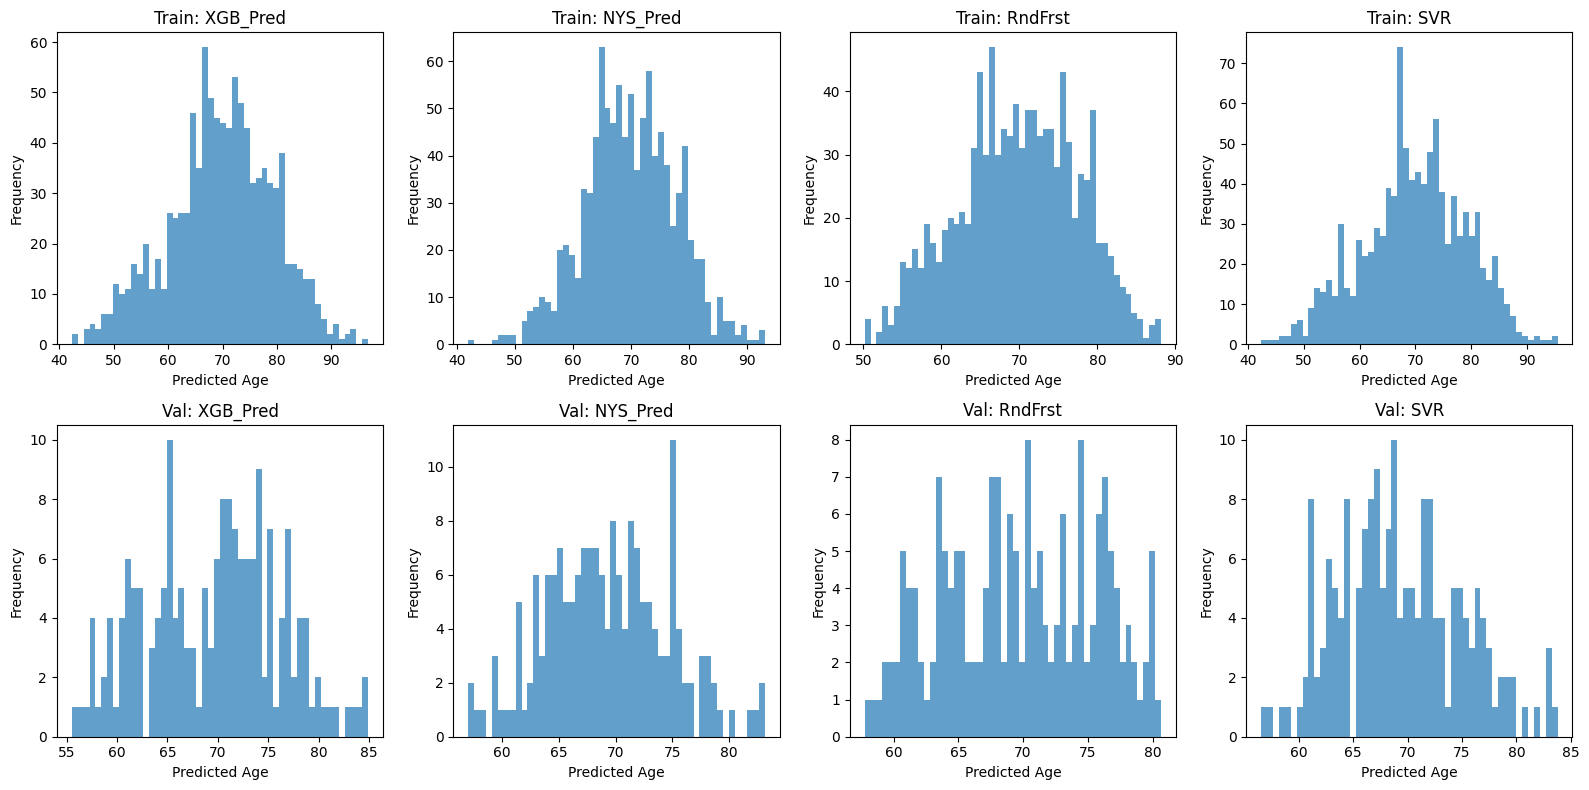

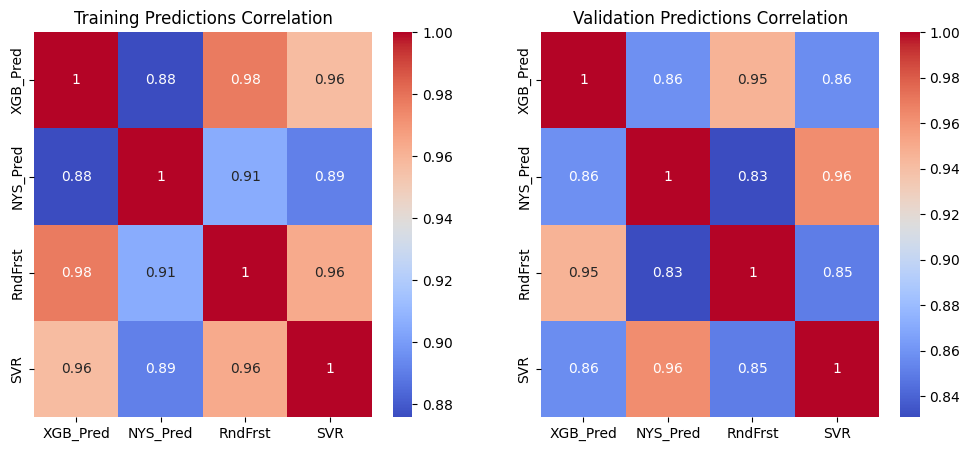

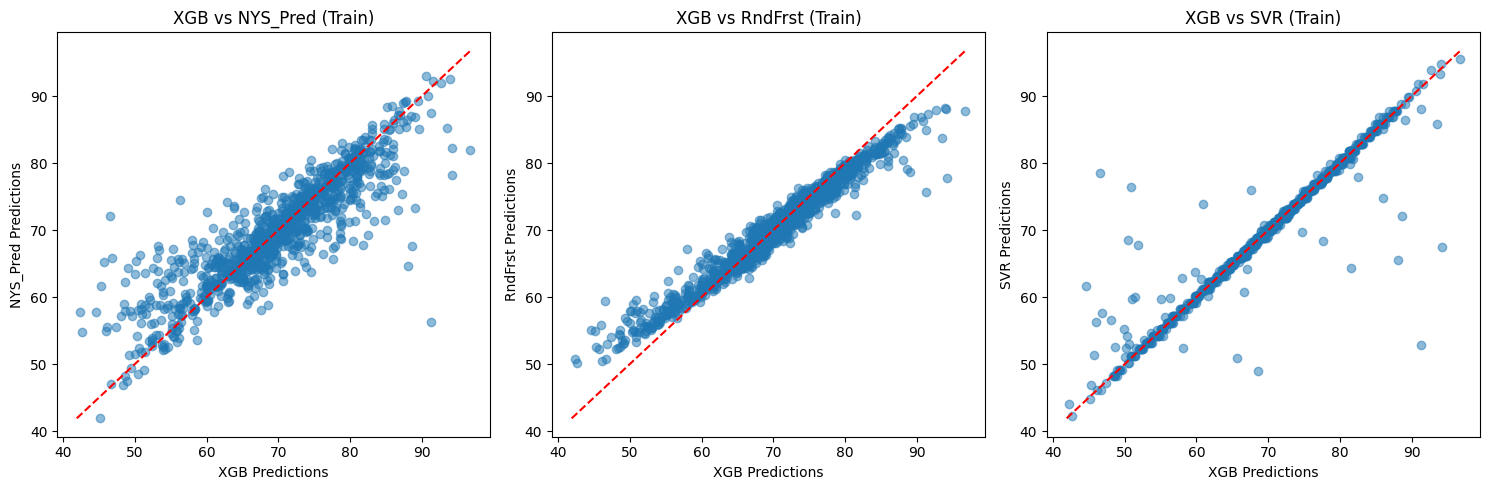

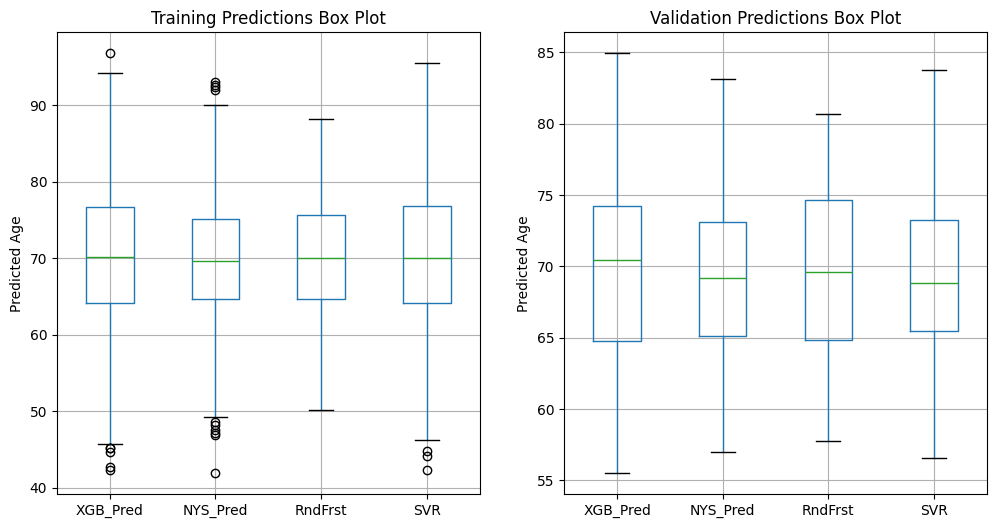

Training Predictions Stats:
          XGB_Pred     NYS_Pred      RndFrst          SVR
count  1014.000000  1014.000000  1014.000000  1014.000000
mean     69.816307    69.816568    69.823443    69.819696
std       9.545675     7.889806     7.672112     9.235133
min      42.297943    41.902597    50.156050    42.321014
25%      64.175854    64.649351    64.632211    64.179864
50%      70.126606    69.678970    70.052643    69.987436
75%      76.705837    75.102818    75.643156    76.819600
max      96.772537    93.022656    88.177308    95.480222

Validation Predictions Stats:
         XGB_Pred    NYS_Pred     RndFrst         SVR
count  179.000000  179.000000  179.000000  179.000000
mean    69.587997   69.275190   69.697025   69.390649
std      6.629988    5.431144    5.857940    5.668128
min     55.508171   56.989695   57.753397   56.536737
25%     64.755669   65.135893   64.817374   65.479797
50%     70.412918   69.147048   69.603497   68.813813
75%     74.242123   73.078369   74.629631

In [49]:
primary_model_preds_train = {
    "XGB_Pred": y_train_pred_xgb,
    "NYS_Pred": y_train_pred_nys,
    "RndFrst": y_train_pred_rndm_frst,
    "SVR": y_train_pred_svr,
}

primary_model_preds = {
    "XGB_Pred": y_pred_xgb,
    "NYS_Pred": y_pred_nys,
    "RndFrst": y_pred_rndm_frst,
    "SVR": y_pred_svr,
}

# Data analysis on model predictions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrame for training predictions
pred_train_df = pd.DataFrame(primary_model_preds_train)
pred_val_df = pd.DataFrame(primary_model_preds)

# 1. Histograms of predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, col in enumerate(pred_train_df.columns):
    axes[0, i].hist(pred_train_df[col], bins=50, alpha=0.7)
    axes[0, i].set_title(f'Train: {col}')
    axes[0, i].set_xlabel('Predicted Age')
    axes[0, i].set_ylabel('Frequency')

for i, col in enumerate(pred_val_df.columns):
    axes[1, i].hist(pred_val_df[col], bins=50, alpha=0.7)
    axes[1, i].set_title(f'Val: {col}')
    axes[1, i].set_xlabel('Predicted Age')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 2. Correlation heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(pred_train_df.corr(), annot=True, cmap='coolwarm', ax=ax1)
ax1.set_title('Training Predictions Correlation')
sns.heatmap(pred_val_df.corr(), annot=True, cmap='coolwarm', ax=ax2)
ax2.set_title('Validation Predictions Correlation')
plt.show()

# 3. Scatter plots comparing XGB vs others (train)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
models = ['NYS_Pred', 'RndFrst', 'SVR']
for i, model in enumerate(models):
    axes[i].scatter(pred_train_df['XGB_Pred'], pred_train_df[model], alpha=0.5)
    axes[i].set_xlabel('XGB Predictions')
    axes[i].set_ylabel(f'{model} Predictions')
    axes[i].set_title(f'XGB vs {model} (Train)')
    axes[i].plot([pred_train_df.min().min(), pred_train_df.max().max()], 
                 [pred_train_df.min().min(), pred_train_df.max().max()], 'r--')
plt.tight_layout()
plt.show()

# 4. Box plots for distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
pred_train_df.boxplot(ax=ax1)
ax1.set_title('Training Predictions Box Plot')
ax1.set_ylabel('Predicted Age')
pred_val_df.boxplot(ax=ax2)
ax2.set_title('Validation Predictions Box Plot')
ax2.set_ylabel('Predicted Age')
plt.show()

# 5. Mean and std of predictions
print("Training Predictions Stats:")
print(pred_train_df.describe())
print("\nValidation Predictions Stats:")
print(pred_val_df.describe())

In [ ]:
import torch.nn as nn

# Define a simple MLP module
class MLPres(nn.Module):
    def __init__(self, input_dim, activation, hidden_units=128, num_layers=2, dropout=0.0):
        super(MLPres, self).__init__()
        layers = [nn.Linear(input_dim, hidden_units), activation(), nn.Dropout(dropout)]
        for _ in range(1, num_layers):
            layers.extend([nn.Linear(hidden_units, hidden_units), activation(), nn.Dropout(dropout)])
        layers.append(nn.Linear(hidden_units, 1))
        # Removed Softplus for residual training (residuals can be negative)
        self.network = nn.Sequential(*layers)
        
        # Initialize weights using Xavier for linear layers
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [67]:
import torch.nn as nn

# Define a simple MLP module
class MLP(nn.Module):
    def __init__(self, input_dim, activation, hidden_units=128, num_layers=2, dropout=0.0):
        super(MLP, self).__init__()
        layers = [nn.Linear(input_dim, hidden_units), activation(), nn.Dropout(dropout)]
        for _ in range(1, num_layers):
            layers.extend([nn.Linear(hidden_units, hidden_units), activation(), nn.Dropout(dropout)])
        layers.append(nn.Linear(hidden_units, 1))
        layers.append(nn.Linear(1, 1))  # 1-1 linear layer for scaling/shifting
        layers.append(nn.Softplus())    # Softplus activation to ensure positive output
        self.network = nn.Sequential(*layers)
        
        # Initialize weights using Xavier for linear layers
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [68]:

#------------------------------------
"""The idea is to let train nystroem and XGB as good as possible, then feed the results to a small neural network, alongside the most relevant features."""
def create_nnet_input(X: pd.DataFrame, **model_preds) -> pd.DataFrame:
    """
    Create input features for the neural network by combining selected features and model predictions.
    
    Parameters:
    X (pd.DataFrame): Input feature DataFrame
    model_preds (dict): Dictionary of model predictions with model names as keys and prediction arrays as values
    
    Returns:
    pd.DataFrame: DataFrame containing selected features and model predictions
    """
    primary_model_features = [pd.Series(pred, name=model_name, index=X.index) for model_name, pred in model_preds.items()]
    X = pd.concat([X] + primary_model_features, axis=1)
    assert (isinstance(X, pd.DataFrame)), "Output is not a DataFrame"
    return X

#create the input features for the neural network
primary_model_preds_train = {
    "XGB_Pred": y_train_pred_xgb,
    "NYS_Pred": y_train_pred_nys,
    "RndFrst": y_train_pred_rndm_frst,
    "SVR": y_train_pred_svr,
}
primary_model_preds = {
    "XGB_Pred": y_pred_xgb,
    "NYS_Pred": y_pred_nys,
    "RndFrst": y_pred_rndm_frst,
    "SVR": y_pred_svr,
}

print(f"considering {len(features_nnet)} primary features for NN")
nnet_inp = create_nnet_input(X_train[features_nnet], **primary_model_preds_train)
nnet_val = create_nnet_input(X_val[features_nnet], **primary_model_preds)
#convert to skorch compatible format
nnet_inp = nnet_inp.astype(np.float32).values
nnet_val = nnet_val.astype(np.float32).values
y_train = y_train.astype(np.float32).values
y_val = y_val.astype(np.float32).values

#now we do a hyperparam search for the neural network
input_layer_dim = int(nnet_inp.shape[1])
print("Input layer dim for NN:", input_layer_dim)
nn_param_grid = {
    "TorchNN": {
            "model": NeuralNetRegressor(
                module=MLP,
                module__input_dim=input_layer_dim,  # Correct input dim
                criterion=nn.MSELoss,
                optimizer=optim.Adam,
                verbose=1,
                callbacks=[EarlyStopping(monitor='valid_loss', patience=100, threshold=0.0001)]

            ),
            "params": {
                "TorchNN__module__hidden_units": [input_layer_dim * 2, input_layer_dim * 3],
                "TorchNN__module__num_layers": [3,4,5],
                "TorchNN__module__dropout": [0.3, 0.4, 0.5],
                "TorchNN__module__activation" : [nn.Sigmoid,nn.ReLU, nn.LeakyReLU, nn.ELU],
                "TorchNN__optimizer__lr": [0.02, 0.01],
                "TorchNN__optimizer__weight_decay": [0.01, 0.03],
                "TorchNN__batch_size": [32, 64],
                "TorchNN__max_epochs": [500]
            },
        },
}

nn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("TorchNN", nn_param_grid["TorchNN"]["model"])
])

param_grid = nn_param_grid["TorchNN"]["params"]

nn_gs = RandomizedSearchCV(
    estimator=nn_pipeline,
    param_distributions=param_grid,
    scoring="neg_mean_absolute_error",
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2,
    n_iter=10,
    random_state=42,

)

nn_gs.fit(nnet_inp, y_train)
y_pred_train_ensemble = nn_gs.predict(nnet_inp)
y_pred_val_ensemble = nn_gs.predict(nnet_val)

print(f"→ Ensemble NNet | Train R²: {r2_score(y_train, y_pred_train_ensemble):.4f} | Test R²: {r2_score(y_val, y_pred_val_ensemble):.4f} | Test MAE: {mean_absolute_error(y_val, y_pred_val_ensemble):.4f}")
print("Best NN params:", nn_gs.best_params_)

considering 15 primary features for NN


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [63]:
#TODO: lets try residual training instead


#create the input features for the neural network
primary_model_preds_train = {
    "XGB_Pred": y_train_pred_xgb,
    "NYS_Pred": y_train_pred_nys,
    "RndFrst": y_train_pred_rndm_frst,
    "SVR": y_train_pred_svr,
}
primary_model_preds = {
    "XGB_Pred": y_pred_xgb,
    "NYS_Pred": y_pred_nys,
    "RndFrst": y_pred_rndm_frst,
    "SVR": y_pred_svr,
}

print(f"considering {len(features_nnet)} primary features for NN")
nnet_inp = create_nnet_input(X_train[features_nnet], **primary_model_preds_train)
nnet_val = create_nnet_input(X_val[features_nnet], **primary_model_preds)
#convert to skorch compatible format
nnet_inp = nnet_inp.astype(np.float32).values
nnet_val = nnet_val.astype(np.float32).values

# Compute mean predictions for residual training
mean_pred_train = np.mean([y_train_pred_xgb, y_train_pred_nys, y_train_pred_rndm_frst, y_train_pred_svr], axis=0)
mean_pred_val = np.mean([y_pred_xgb, y_pred_nys, y_pred_rndm_frst, y_pred_svr], axis=0)

# Residual targets
y_train_residual = y_train - mean_pred_train
y_val_residual = y_val - mean_pred_val

y_train_residual = y_train_residual.astype(np.float32)
y_val_residual = y_val_residual.astype(np.float32)

#now we do a hyperparam search for the neural network
input_layer_dim = int(nnet_inp.shape[1])
print("Input layer dim for NN:", input_layer_dim)
nn_param_grid = {
    "TorchNN": {
            "model": NeuralNetRegressor(
                module=MLP,
                module__input_dim=input_layer_dim,  # Correct input dim
                criterion=nn.MSELoss,
                optimizer=optim.Adam,
                verbose=1,
                callbacks=[EarlyStopping(monitor='valid_loss', patience=50, threshold=0.0001)]

            ),
            "params": {
                "TorchNN__module__hidden_units": [input_layer_dim * 2, input_layer_dim * 3],
                "TorchNN__module__num_layers": [5, 7, 10, 15],
                "TorchNN__module__dropout": [0, 0.1,],
                "TorchNN__module__activation" : [nn.Sigmoid,nn.ReLU],
                "TorchNN__optimizer__lr": [0.05, 0.02],
                "TorchNN__batch_size": [32, 50],
                "TorchNN__max_epochs": [300]
            },
        },
}


nn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("TorchNN", nn_param_grid["TorchNN"]["model"])
])

param_grid = nn_param_grid["TorchNN"]["params"]

nn_gs = RandomizedSearchCV(
    estimator=nn_pipeline,
    param_distributions=param_grid,
    scoring="neg_mean_absolute_error",
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2,
    n_iter=10,
    random_state=42,

)

nn_gs.fit(nnet_inp, y_train_residual)
residual_pred_train = nn_gs.predict(nnet_inp).flatten()
residual_pred_val = nn_gs.predict(nnet_val).flatten()

# Final predictions: mean base + residual
y_pred_train_ensemble = mean_pred_train + residual_pred_train
y_pred_val_ensemble = mean_pred_val + residual_pred_val

print(f"→ Ensemble NNet (Residual) | Train R²: {r2_score(y_train, y_pred_train_ensemble):.4f} | Test R²: {r2_score(y_val, y_pred_val_ensemble):.4f} | Test MAE: {mean_absolute_error(y_val, y_pred_val_ensemble):.4f}")
print("Best NN params:", nn_gs.best_params_)

considering 15 primary features for NN
Input layer dim for NN: 19
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Cédric\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\conda\envs\LRF\lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([32, 1014])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      701.4733      130.7058  0.3935


c:\conda\envs\LRF\lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([11, 1014])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


      2      139.9673      134.9928  0.3985
      3      139.3463      125.8481  0.3605
      3      139.3463      125.8481  0.3605
      4      132.6847      131.1674  0.3336
      4      132.6847      131.1674  0.3336
      5      144.1543      147.6191  0.3284
      5      144.1543      147.6191  0.3284
      6      134.3093      132.8882  0.3229
      6      134.3093      132.8882  0.3229
      7      142.4920      141.6725  0.3328
      7      142.4920      141.6725  0.3328
      8      146.4885      134.3526  0.3539
      8      146.4885      134.3526  0.3539
      9      143.0181      136.2607  0.3252
      9      143.0181      136.2607  0.3252
     10   202908.8395      166.6345  0.3227
     10   202908.8395      166.6345  0.3227
     11      164.5233      166.6345  0.3311
     11      164.5233      166.6345  0.3311
     12      164.5150      166.6345  0.3442
     12      164.5150      166.6345  0.3442
     13      164.5150      166.6345  0.3196
     13      164.5150      166.6

In [ ]:
def final_training(model):
        #TODO for ensemble
    return model

# Train the model once again on the full dataset for the public test

# Save the test results for online evaluation

In [ ]:
from datetime import datetime

results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

def save_test_predictions(model, model_name)-> Path:
    model = final_training(model)
    save_path = results_dir / f"test_{model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"

    y_test_pred = model.predict(X_test[X_selected.columns])
    results_df = pd.DataFrame(y_test_pred, index=X_test.index, columns=["y"])
    assert (results_df.shape == (776, 1)), f"Unexpected shape: {results_df.shape}"
    results_df.to_csv(save_path)
    print(f"Test predictions saved to {save_path}")
    return save_path

file = save_test_predictions(XGBRegressor, "xgboost")

{'model__subsample': 0.6, 'model__reg_alpha': 0.6, 'model__n_estimators': 600, 'model__max_depth': 9, 'model__learning_rate': 0.02, 'model__gamma': 1, 'model__colsample_bytree': 0.7}


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [10:38:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__reg_alpha", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test predictions saved to results/test_xgboost_20251104_103859.csv


'kaggle competitions submit -c eth-aml-2025-project-1 -f submission.csv -m "Message"'

In [ ]:
#upload to kaggle

import subprocess

#submit predictions
def submit_predictions(file:Path, message:str) -> None:
    cmd = f'kaggle competitions submit -c eth-aml-2025-project-1 -f {file} -m "{message}"'
    res = subprocess.run(cmd, shell=True, check=True)
    print(res.stdout, res.stderr)

submit_msg = input("Enter submission message: ")
submit_predictions(file, submit_msg)

100%|██████████| 9.93k/9.93k [00:00<00:00, 25.4kB/s]


Successfully submitted to ETH AML 2025 Project 1None None
